
[Phase 1] : Data Preparation
| Preparing CIFAR-100 dataset...
| Files already downloaded and verified

[Phase 2] : Model setup for Hard Voting Ensemble
| Building net types for ensemble...
| Wide-Resnet 28x14
| Wide-Resnet 28x16
| Wide-Resnet 28x18

=> Training Epoch #1, LR=0.1000
| Epoch [  1/ 95] Iter[391/391]		Loss: 4.2037 Acc@1: 5.532%-----------------Ensemble Model----------------------
| Validation Epoch #1			Acc@1: 10.75%
* General Top-1 Accuracy = 10.75%
* General Top-5 Accuracy = 33.33%
* Superclass Top-1 Accuracy = 21.92%
* Superclass Top-5 Accuracy = 54.81%
| Updating Best Top-1 model...			Acc@1 = 10.75%
| Updating Best Top-5 model...			Acc@5 = 33.33%
| Updating Best Superclass Top-1 model...			Acc@1 Superclass = 21.92%
| Elapsed time: 0:12:59

=> Training Epoch #2, LR=0.1000
| Epoch [  2/ 95] Iter[391/391]		Loss: 3.3363 Acc@1: 9.258%-----------------Ensemble Model----------------------
| Validation Epoch #2			Acc@1: 14.25%
* General Top-1 Accuracy = 14.25%
* General Top-5 

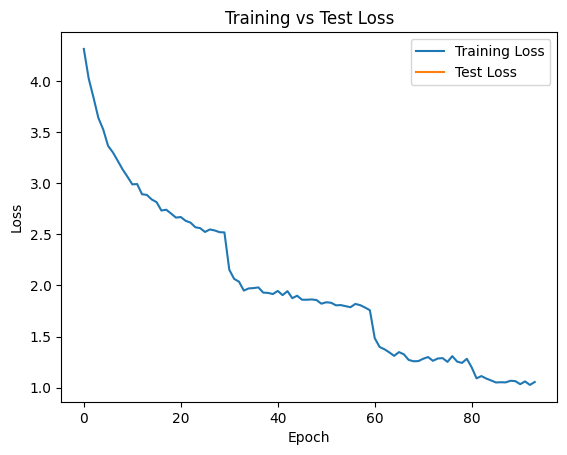

In [1]:
from __future__ import print_function
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import config as cf

import torchvision
import torchvision.transforms as transforms

import os
import sys
import time
import argparse
import datetime

from wide_resnet import *  # Wide_resnet.py
from torch.autograd import Variable
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
parser = argparse.ArgumentParser(description='PyTorch CIFAR-10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning_rate')
parser.add_argument('--seed', default=27, type=int, help='seed')
parser.add_argument('--net_type', default='wide-resnet', type=str, help='model')
parser.add_argument('--depth', default=28, type=int, help='depth of model')
parser.add_argument('--widen_factor_1', default=14, type=int, help='width of model')
parser.add_argument('--widen_factor_2', default=16, type=int, help='width of model')
parser.add_argument('--widen_factor_3', default=18, type=int, help='width of model')
parser.add_argument('--dropout', default=0.2, type=float, help='dropout_rate')
parser.add_argument('--dataset', default='cifar100', type=str, help='dataset = cifar100')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
parser.add_argument('--testOnly', '-t', action='store_true', help='Test mode with the saved model')
args = parser.parse_args(args=[])

# Seed setup
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

def map_to_superclass(labels, class_to_superclass):
    return [class_to_superclass[label] for label in labels]

def seed_worker(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)

# Hyperparameter settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
best_acc = 0
start_epoch, num_epochs, batch_size, optim_type = cf.start_epoch, cf.num_epochs, cf.batch_size, cf.optim_type

train_losses = []  # List to store training losses
test_losses = []   # List to store test losses

# Data Upload
print('\n[Phase 1] : Data Preparation')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[args.dataset], cf.std[args.dataset]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[args.dataset], cf.std[args.dataset]),
])

print("| Preparing CIFAR-100 dataset...")
sys.stdout.write("| ")
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform=transform_test)
num_classes = 100

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, worker_init_fn=seed_worker)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

# CIFAR-100 Superclass mapping (index-based)
superclass_mapping = {
    0: [4, 30, 55, 72, 95],  # aquatic mammals
    1: [1, 32, 67, 73, 91],  # fish
    2: [54, 62, 70, 82, 92],  # flowers
    3: [9, 10, 16, 28, 61],  # food containers
    4: [0, 51, 53, 57, 83],  # fruit and vegetables
    5: [22, 39, 40, 86, 87],  # household electrical devices
    6: [5, 20, 25, 84, 94],  # household furniture
    7: [6, 7, 14, 18, 24],   # insects
    8: [3, 42, 43, 88, 97],  # large carnivores
    9: [12, 17, 37, 68, 76],  # large man-made outdoor things
    10: [23, 33, 49, 60, 71],  # large natural outdoor scenes
    11: [15, 19, 21, 31, 38],  # large omnivores and herbivores
    12: [34, 63, 64, 66, 75],  # medium-sized mammals
    13: [26, 45, 77, 79, 99],  # non-insect invertebrates
    14: [2, 11, 35, 46, 98],  # people
    15: [27, 29, 44, 78, 93],  # reptiles
    16: [36, 50, 65, 74, 80],  # small mammals
    17: [47, 52, 56, 59, 96],  # trees
    18: [8, 13, 48, 58, 90],  # vehicles 1
    19: [41, 69, 81, 85, 89],  # vehicles 2
}

# Create a list to store which superclass each class belongs to
class_to_superclass = [None] * 100
for super_idx, class_indices in superclass_mapping.items():
    for class_idx in class_indices:
        class_to_superclass[class_idx] = super_idx

# CutMix function
def cutmix_data(x, y, beta=1.0):
    if beta > 0:
        lam = np.random.beta(beta, beta)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    y_a, y_b = y, y[index]

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    
    return x, y_a, y_b, lam

# Random box function for CutMix
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Return Wide-ResNet network and filename
def get_ensemble_networks(args):
    net1 = Wide_ResNet(args.depth, args.widen_factor_1, args.dropout, num_classes)
    net2 = Wide_ResNet(args.depth, args.widen_factor_2, args.dropout, num_classes)
    net3 = Wide_ResNet(args.depth, args.widen_factor_3, args.dropout, num_classes)
    file_name1 = 'wide-resnet1-'+str(args.depth)+'x'+str(args.widen_factor_1)
    file_name2 = 'wide-resnet2-'+str(args.depth)+'x'+str(args.widen_factor_2)
    file_name3 = 'wide-resnet3-'+str(args.depth)+'x'+str(args.widen_factor_3)
    return [net1, net2, net3], [file_name1, file_name2, file_name3]


# Model setup
print('\n[Phase 2] : Model setup for Hard Voting Ensemble')
print('| Building net types for ensemble...')
nets, file_names = get_ensemble_networks(args)
for net in nets:
    net.apply(conv_init)

if use_cuda:
    for i, net in enumerate(nets):
        nets[i] = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
        nets[i].cuda()
    cudnn.benchmark = True


if use_cuda:
    for i, net in enumerate(nets):
        nets[i] = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
        nets[i].cuda()
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Hard Voting Prediction
def hard_voting_prediction(outputs_list):
    """Performs hard voting by choosing the most common prediction."""
    outputs_stack = torch.stack(outputs_list)  # Stack outputs from all models
    voted_predictions, _ = torch.mode(outputs_stack, dim=0)  # Hard voting
    return voted_predictions

# Training function
def train(epoch):
    
    optimizers = [optim.SGD(net.parameters(), lr=cf.learning_rate(args.lr, epoch), momentum=0.9, weight_decay=5e-4) for net in nets]
    
    for net in nets:
        net.train()

    train_loss = 0
    correct = 0
    total = 0
    
    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, cf.learning_rate(args.lr, epoch)))
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs), Variable(targets)
        inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, beta=1.0)
        
        
        for i, net in enumerate(nets):
            optimizers[i].zero_grad()
            outputs = net(inputs) 
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            loss.backward() 
            optimizers[i].step()  

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                         % (epoch, num_epochs, batch_idx+1,
                            (len(trainset)//batch_size)+1, loss.item(), 100.*correct/total))
        sys.stdout.flush()

    train_loss = train_loss / len(trainloader)
    train_losses.append(train_loss)

best_acc = 0
best_top5_acc = 0
best_superclass_top1_acc = 0

# Test function with hard voting ensemble
def test_ensemble(epoch):
    global best_acc, best_top5_acc, best_superclass_top1_acc
    for net in nets:
        net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    correct_top1_general = 0
    correct_top5_general = 0
    correct_top1_superclass = 0
    correct_top5_superclass = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs), Variable(targets)

            # Get outputs from all models
            outputs_list = [net(inputs) for net in nets]

            # Hard voting for Top-1 predictions
            outputs_avg = sum(outputs_list) / len(outputs_list)  # Average logits for top-5 
            top5_pred = torch.topk(outputs_avg, 5, dim=1)[1]  # General top-5 prediction
            voted_top1 = hard_voting_prediction([torch.argmax(out, dim=1) for out in outputs_list])

            total += targets.size(0)
            correct += voted_top1.eq(targets.data).cpu().sum()

            correct_top1_general += voted_top1.eq(targets.data).cpu().sum()
            correct_top5_general += sum([targets[i] in top5_pred[i] for i in range(targets.size(0))])

            # Superclass accuracy
            true_superclass = torch.tensor(map_to_superclass(targets.cpu().numpy(), class_to_superclass)).to(device)
            pred_superclasses_top1 = torch.tensor(map_to_superclass(voted_top1.cpu().numpy(), class_to_superclass)).to(device)

            correct_top1_superclass += (pred_superclasses_top1 == true_superclass).sum().item()

            pred_superclasses_top5 = [torch.tensor(map_to_superclass(pred.cpu().numpy(), class_to_superclass)).to(device) for pred in top5_pred]
            for i in range(targets.size(0)):
                true_label_superclass = true_superclass[i].item()
                if true_label_superclass in pred_superclasses_top5[i].cpu().numpy():
                    correct_top5_superclass += 1

        # Test results output
        acc_top1_general = 100. * correct_top1_general / total
        acc_top5_general = 100. * correct_top5_general / total
        acc_top1_superclass = 100. * correct_top1_superclass / total
        acc_top5_superclass = 100. * correct_top5_superclass / total

        acc = 100.*correct/total
        print(f"-----------------Ensemble Model----------------------")
        print("| Validation Epoch #%d\t\t\tAcc@1: %.2f%%" %(epoch, acc))
        print(f"* General Top-1 Accuracy = {acc_top1_general:.2f}%")
        print(f"* General Top-5 Accuracy = {acc_top5_general:.2f}%")
        print(f"* Superclass Top-1 Accuracy = {acc_top1_superclass:.2f}%")
        print(f"* Superclass Top-5 Accuracy = {acc_top5_superclass:.2f}%")

        checkpoint_dir = './checkpoint/' + args.dataset + os.sep
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        
        # Save model if best accuracy is achieved for each metric
        if acc > best_acc:
            best_acc = acc
            print('| Updating Best Top-1 model...\t\t\tAcc@1 = %.2f%%' % (acc))
            torch.save({
                'net': nets,
                'acc': best_acc,
                'epoch': epoch,
            }, checkpoint_dir + 'best_top1_model.pth')
        
        if acc_top5_general > best_top5_acc:
            best_top5_acc = acc_top5_general
            print('| Updating Best Top-5 model...\t\t\tAcc@5 = %.2f%%' % (acc_top5_general))
            torch.save({
                'net': nets,
                'acc': best_top5_acc,
                'epoch': epoch,
            }, checkpoint_dir + 'best_top5_model.pth')
        
        if acc_top1_superclass > best_superclass_top1_acc:
            best_superclass_top1_acc = acc_top1_superclass
            print('| Updating Best Superclass Top-1 model...\t\t\tAcc@1 Superclass = %.2f%%' % (acc_top1_superclass))
            torch.save({
                'net': nets,
                'acc': best_superclass_top1_acc,
                'epoch': epoch,
            }, checkpoint_dir + 'best_superclass_top1_model.pth')
        
    return acc_top1_general, acc_top5_general, acc_top1_superclass, acc_top5_superclass

# Main training and testing loop
if not args.testOnly:
    elapsed_time = 0
    for epoch in range(start_epoch, num_epochs):
        start_time = time.time()

        train(epoch)
        test_ensemble(epoch)

        epoch_time = time.time() - start_time
        elapsed_time += epoch_time
        print(f'| Elapsed time: {int(elapsed_time//3600)}:{int((elapsed_time % 3600)//60)}:{int(elapsed_time % 60)}')

# Final testing with ensemble after all epochs
print('\n[Phase 4] : Testing model ensemble')
top1_acc, top5_acc, top1_superclass_acc, top5_superclass_acc = test_ensemble(cf.num_epochs)
print(f'* Final Test results : Best Acc@1 = {best_acc:.2f}%, Best Acc@5 = {best_top5_acc:.2f}%, Best Superclass Acc@1 = {best_superclass_top1_acc:.2f}%')

# Visualizing the training vs test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.show()